In [1]:
from __future__ import annotations

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.base_strategy import BaseStrategy
from wufam.backtest.rolling_backtest import run_rolling_backtest
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_100_D
FACTORS_DATASET = Dataset.FACTORS_D
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 252

## 1.1

In [3]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

## 1.2

In [5]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.optimized.mean_var import MeanVariance
from wufam.strategies.optimized.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [6]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [7]:
min_var_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [8]:
trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_min_var,
    window_size=None,
)

In [9]:
trading_config_naive_min_var = TradingConfig(total_exposure=1, min_exposure=0.5 / 100)

min_var_naive_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_naive_min_var,
    window_size=None,
)

In [10]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

min_var_lw_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [11]:
min_var_lw_cv_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    trading_config=trading_config,
    window_size=None,
)

In [12]:
def evaluate_strategy(
    strategy: BaseStrategy, return_weights: bool = False
) -> tuple[float, float] | tuple[float, float, pd.DataFrame]:
    bt_res = run_rolling_backtest(
        strategy=strategy,
        excess_returns=portfolios_xs_r,
        factors=factors_df,
        rf=rf,
        freq="M",
        trading_lag=1,
        return_weights=return_weights,
    )

    if return_weights:
        total_r, turnover, me_weights = bt_res
    else:
        total_r, turnover = bt_res

    sr = calc_sharpe(
        strategy_total_r=total_r,
        rf_rate=rf,
        factor_annualize=FACTOR_ANNUALIZE,
    )

    if return_weights:
        return sr, turnover.mean(), me_weights
    return sr, turnover.mean()

In [13]:
evaluate_strategy(ew_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 690.58it/s] 


(0.2534679603178763, np.float64(0.026210072487091163))

In [14]:
evaluate_strategy(mv_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:03<00:00, 219.56it/s]


(0.2593703441819935, np.float64(13.483803533322703))

In [15]:
evaluate_strategy(min_var_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:02<00:00, 245.80it/s]


(0.6152040598969939, np.float64(1.2611056396714067))

In [16]:
evaluate_strategy(min_var_c_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:18<00:00, 35.34it/s]


(0.7345837723955494, np.float64(0.04522691076267253))

In [17]:
evaluate_strategy(min_var_lw_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:04<00:00, 158.60it/s]


(1.2040693270575282, np.float64(0.2471622855638472))

In [18]:
evaluate_strategy(min_var_lw_cv_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [15:40<00:00,  1.43s/it]


(0.5750722128631303, np.float64(0.1953861231982358))

In [19]:
from wufam.strategies.timed.vol_managed_strategy import VolManagedStrategy
from wufam.estimation.covariance.factor.factor_cov_estimator import FactorCovEstimator
from wufam.estimation.covariance.shrinkage.pca_cov_estimator import PCACovEstimator
from wufam.estimation.covariance.shrinkage.qis import QISCovEstimator

min_var_qis_strategy = MinVariance(
    cov_estimator=QISCovEstimator(),
    trading_config=trading_config,
    window_size=365,
)

factor_cov_estimator = FactorCovEstimator(
    factor_cov_estimator=SampleCovEstimator(),
    residual_cov_estimator=PCACovEstimator(),
    factors_selection=["Mkt-RF"],
)

min_var_factor_strategy = MinVariance(
    cov_estimator=factor_cov_estimator,
    trading_config=trading_config,
    window_size=365,
)

vol_managed_trading_config = TradingConfig(min_exposure=0.0, max_exposure=2.0)

vol_managed_strategy = VolManagedStrategy(
    trading_config=vol_managed_trading_config,
    vol_window=21,
)

In [25]:
sr, t, we = evaluate_strategy(min_var_factor_strategy, return_weights=True)
sr, t

Optimizing Strategy: 100%|██████████| 659/659 [01:00<00:00, 10.91it/s]


(nan, np.float64(1.6048773993952283))

In [26]:
we

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
1970-01-30,-0.068886,-0.048749,-0.064621,0.002639,-0.013521,0.000862,-0.042087,0.008566,0.041345,0.076888,...,-0.08909,0.103631,0.143762,0.01573,0.059139,0.00378,0.06027,0.025311,0.010485,0.010827
1970-02-02,-0.06956,-0.049045,-0.065543,0.002651,-0.013684,0.00087,-0.042515,0.008619,0.041688,0.077055,...,-0.090264,0.10453,0.144923,0.015896,0.060001,0.003822,0.060467,0.025475,0.010599,0.010953
1970-02-03,-0.070359,-0.049262,-0.066511,0.002664,-0.013759,0.000874,-0.042467,0.008582,0.041732,0.076892,...,-0.090835,0.105368,0.145753,0.016003,0.060374,0.003862,0.061066,0.025542,0.010578,0.011053
1970-02-04,-0.068582,-0.048622,-0.065156,0.002624,-0.013629,0.000865,-0.042165,0.008506,0.041239,0.076444,...,-0.089409,0.103578,0.144759,0.015892,0.060438,0.00383,0.060576,0.025533,0.01045,0.011002
1970-02-05,-0.068758,-0.048259,-0.065415,0.002607,-0.013582,0.000867,-0.041981,0.008472,0.041295,0.076487,...,-0.090096,0.104187,0.144244,0.015922,0.060708,0.003739,0.060744,0.025522,0.010471,0.010854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.024754,0.010403,0.006374,-0.001295,0.002944,0.042193,0.054164,0.102756,0.127258,0.12878,...,-0.090435,0.235288,0.028066,0.176141,0.029906,0.036136,0.09594,0.051146,-0.029195,-0.053853
2024-12-26,0.025444,0.010914,0.006421,-0.001335,0.002979,0.042853,0.054915,0.103528,0.13045,0.131575,...,-0.089706,0.233064,0.027767,0.174878,0.029682,0.035895,0.095443,0.050815,-0.029052,-0.053836
2024-12-27,0.025215,0.010812,0.006324,-0.00131,0.002923,0.042291,0.054343,0.101952,0.129537,0.130721,...,-0.08852,0.231269,0.027684,0.174461,0.029722,0.035914,0.095158,0.050668,-0.02896,-0.053859
2024-12-30,0.025517,0.010814,0.006306,-0.001301,0.002905,0.042466,0.05423,0.101944,0.129735,0.132222,...,-0.087943,0.230112,0.027474,0.1735,0.029743,0.035716,0.094959,0.050511,-0.028827,-0.053638


In [21]:
evaluate_strategy(min_var_qis_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:05<00:00, 126.65it/s]


(0.029891863986325116, np.float64(3.358146979578179))

In [22]:
evaluate_strategy(vol_managed_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 361.74it/s]


(0.1534420475163977, np.float64(0.4468691574962377))

In [23]:
sr, turnover, w = evaluate_strategy(min_var_naive_c_strategy, return_weights=True)
sr, turnover

Optimizing Strategy: 100%|██████████| 659/659 [00:15<00:00, 42.01it/s]


(0.49681635308676625, np.float64(0.03824232192485845))

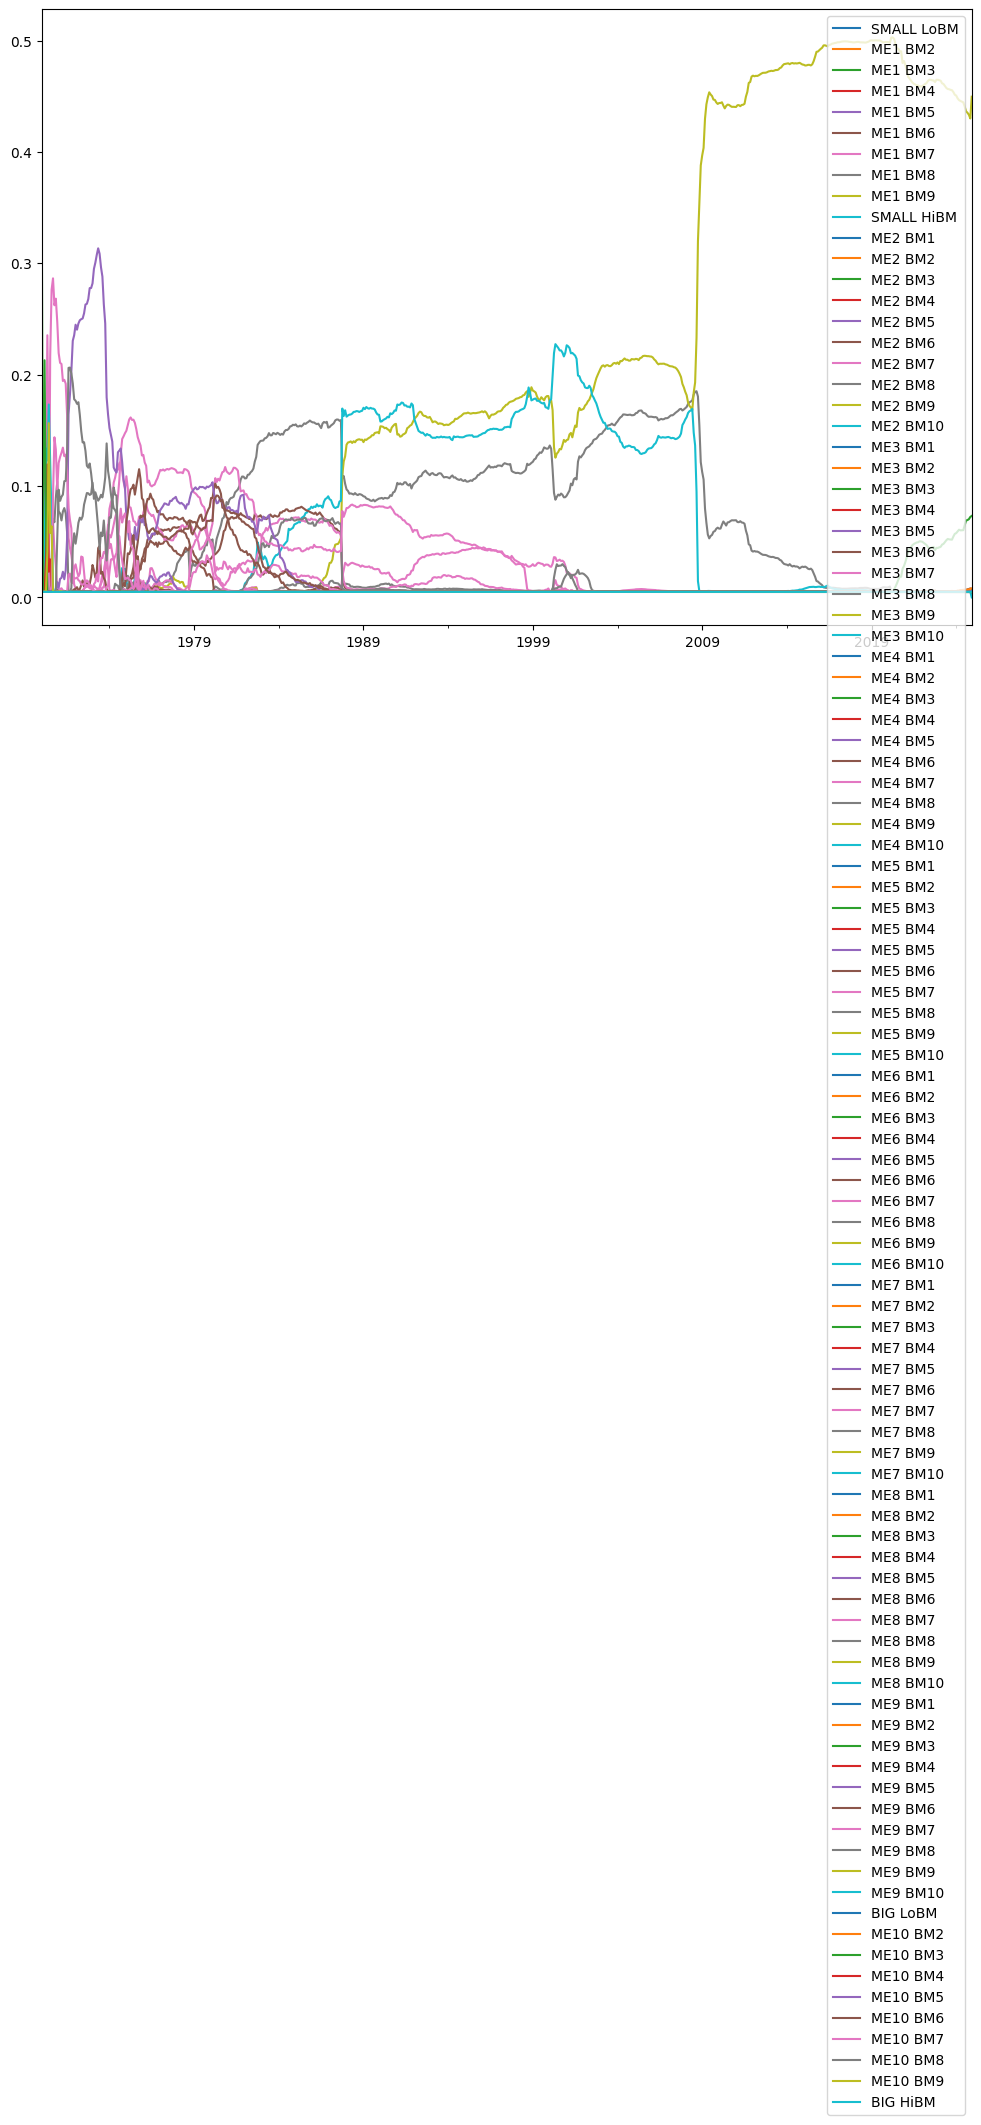

In [24]:
w.resample("ME").last().plot(figsize=(12, 8));